In [1]:
%run 'Functions.ipynb'

In [2]:
class Granularity(Enum):
    second = timedelta(seconds=1)
    minute = timedelta(minutes=1)
    hour = timedelta(hours=1)
    day = timedelta(days=1)
    week = timedelta(weeks=1)
    month = timedelta(hours=730)
    year = timedelta(hours=8760)

In [3]:
def parse_iso_date(str):
    return datetime.strptime(str, '%Y-%m-%dT%H:%M:%S.%fZ')

In [4]:
date = '2015-06-01T00:00:00.00Z'
granularity = 'day'
foreground_window = 7
background_window = 21
min_freq_threshold = 5
smoothing_window = 7
analysis_field = 'abstracts.value'
date_field = 'earliest_date'
index = 'hep-analysis'
doc_type = 'hep'

In [5]:
reference_date = parse_iso_date(date)
gran = Granularity[granularity]
foreground_start = reference_date - foreground_window * gran.value
background_start = reference_date - background_window * gran.value

In [6]:
def interval_ids(index, start, end, date_field, analysis_field):
    q = Search(index=index) \
        .fields(['']) \
        .filter('exists', field=analysis_field) \
        .filter('range', **{date_field: {'gt': start, 'lte': end}})
    return [elem.meta.id for elem in q.scan()]

In [7]:
def term_vectors(index, doc_type, ids, analysis_field, chunk=100):
    res = []
    for pos in range(0, len(ids), chunk):
        q = client.mtermvectors(
            index=index,
            doc_type=doc_type,
            ids=ids[pos:pos + chunk],
            fields=[analysis_field],
            field_statistics=False,
            term_statistics=True,
            offsets=False,
            payloads=False,
            positions=False,
            realtime=True
        )
        for doc in q['docs']:
            if analysis_field in doc['term_vectors']:
                res.append(doc['term_vectors'][analysis_field]['terms'])
    assert len(ids) == len(res)
    return res

In [8]:
def fold_vectors(vectors):
    words = {}
    for vec in vectors:
        for word, freqs in vec.items():
            if word in words:
                words[word]['term_freq'] += freqs['term_freq']
                words[word]['doc_freq'] += 1
            else:
                words[word] = {
                    'term_total': freqs['ttf'], # estimate
                    'doc_total': freqs['doc_freq'], # estimate
                    'term_freq': freqs['term_freq'],
                    'doc_freq': 1,
                }
    return words

In [9]:
def sorting_freq_threshold(terms, min_freq_threshold):
    filtered = [(term, stats) for term, stats in terms.items() if stats['doc_freq'] >= min_freq_threshold]
    return sorted(filtered, key=lambda elem: -elem[1]['doc_freq'])

In [10]:
def unzip(data):
    if not len(data):
        return [], []
    x, y = zip(*[(parse_iso_date(elem.key_as_string), elem.doc_count) for elem in data])
    return np.array(x), np.array(y)

In [11]:
def date_histogram(index, start, end, granularity, date_field, analysis_field):
    all_terms = Search(index=index)[0:0] \
        .filter('range', **{date_field: {'gt': start, 'lte': end}})
    all_terms.aggs.bucket(
        'hist', 
        'date_histogram', 
        field=date_field, 
        interval=granularity.name,
        format='date_optional_time'
    )
    return unzip(all_terms.execute().aggregations.hist.buckets)

In [12]:
def term_date_histogram(index, term, start, end, granularity, date_field, analysis_field):
    all_terms = Search(index=index)[0:0] \
        .query('match_phrase', **{analysis_field: term}) \
        .filter('range', **{date_field: {'gt': start, 'lte': end}})
    all_terms.aggs.bucket(
        'hist', 
        'date_histogram', 
        field=date_field, 
        interval=granularity.name,
        format='date_optional_time'
    )
    return unzip(all_terms.execute().aggregations.hist.buckets)

In [13]:
def normalize_histogram(x, y, x_full, y_full, granularity, smoothing_window):
    
    before = np.where(x_full == x[0])[0][0]
    after = len(x_full) - np.where(x_full == x[-1])[0][0] - 1
    y_complete = np.append(np.zeros(before), np.append(y, np.zeros(after)))

    window = np.ones(smoothing_window)
    y_smooth = sp.signal.convolve(y_complete, window, mode='valid')
    y_full_smooth = sp.signal.convolve(y_full, window, mode='valid')

    assert len(y_smooth) == len(y_full_smooth)
    
    half_invalid_count = (len(y_complete) - len(y_full_smooth)) // 2
    x_full_smooth = x_full[half_invalid_count:-half_invalid_count]
    assert len(x_full_smooth) == len(y_full_smooth)

    with np.errstate(divide='ignore', invalid='ignore'):
        y_norm = np.divide(y_smooth, y_full_smooth)
        y_norm[~ np.isfinite(y_norm)] = 0
        return x_full_smooth, y_norm

In [14]:
ids = interval_ids(index, foreground_start, reference_date, date_field, analysis_field)
vectors = term_vectors(index, doc_type, ids, analysis_field)
raw_terms = fold_vectors(vectors)
terms = sorting_freq_threshold(raw_terms, min_freq_threshold)

In [15]:
xs, ys = date_histogram(index, background_start, reference_date, gran, date_field, analysis_field)

In [16]:
hists = [term_date_histogram(index, term[0], background_start, reference_date, gran, date_field, analysis_field) for term in terms]

In [17]:
norms = [normalize_histogram(x, y, xs, ys, gran, smoothing_window) for x, y in hists if len(y) >= smoothing_window]

In [18]:
from sklearn.cluster import KMeans

In [31]:
km = KMeans(n_clusters=200)
pred = km.fit_predict([elem[1] for elem in norms])

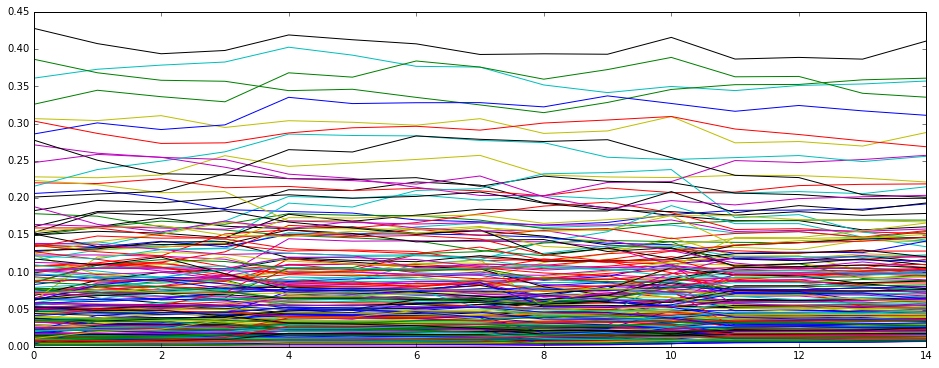

In [32]:
for i, center in enumerate(km.cluster_centers_):
    plt.plot(center, label='c%d: %d' % (i, np.count_nonzero(pred == i)))
#plt.legend()

In [21]:
s = []
for i, cluster in enumerate(pred):
    
    if cluster == 2:
        stats = terms[i][1]
        print(terms[i][0])
        s.append([stats['doc_total'], stats['doc_freq'], stats['doc_freq']])


decay
non
analysis
gamma
investigate
standard
allow
measured
low
value
interaction
range
structure
states
describe
method
property
compare
process
three
perform
state
paper
physics
gev
potential
found
experimental
case
search
provide
number
phase
small
neutron
level
distribution
current
light
production
heavy
approach
recent
cross
within
possible
gamma ray
equation
source
quark
limit
test
collision
quantum
section
strong
due
effects
proton
calculation
nuclear
lhc
background
cross section
region
particular
significant
simulation
coupling
density
standard model
tev
dimension
dark
rate
scatter
develop
however
derive
spectrum
transition
important
boson
studied
hadron
calculate
produce
nuclei
ratio
electron
mode
general
prediction
beam
several
spectra
cosmology
increase
extend
may
set
point
previous
event
gauge
theoretical
photon
spin
work
power
scalar
consistent
form
second
type
emission
solution
sample
effect
propose
future
temperature
signal
masses
framework
symmetry
report
higg
includin

In [22]:
len(norms)

2357